# MOBILITY MOTIFS FROM MRMT 2015

## 1. DATA & SETTINGS

In [8]:
import pandas as pd
import networkx as nx
import math
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import geopandas as gpd
from geopandas.tools import sjoin

from itertools import groupby
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool


pd.set_option('display.max_columns', 999)

In [9]:
# Importing file
mtf_tag = pd.read_pickle('motifs_mrmt_2015_all_tag_purpose.pkl')

## 2. FUNCTIONS

In [10]:
def motif_str(mtf):
    """
    Adds a new column "motif_type_str" to the given dataframe "mtf" with modified values

    Parameters:
    -----------
    mtf : pandas.DataFrame
        The dataframe to modify by adding the "motif_type_str" column.

    Returns:
    --------
    pandas.DataFrame
        The modified dataframe with the new "motif_type_str" column.
    """
    mapping = {'0': 'H', '1': 'C', '2': 'W', '3': 'E', '4': 'S', '5': 'Se', '6': 'B', '7': 'R', '8': 'L', '9': 'A'}
    
    mtf['motif_type_str'] = mtf['motif_type'].apply(lambda x: ','.join([mapping[i] if i in mapping else i for i in x.split(',')]))
    
    return mtf

In [11]:
def plot_motifs_purpose(n_mtfs: int, mtf: pd.DataFrame, column_name: str) -> None:
    """
    Generates a figure with the most frequent motifs from the provided DataFrame using NetworkX to draw the corresponding graphs.

    Args:
        n_mtfs (int): Number of motifs to display.
        mtf (pd.DataFrame): DataFrame containing the motifs to display.
        column_name (str): Name of the column to be used for generating the plot.

    Returns:
        None. The function displays the generated figure.
    """

    # Compute the frequency of each value in the specified column and normalize the counts to obtain percentages
    count_mtf = mtf[column_name].value_counts(normalize=True) *100
    
    # Compute the explained variance based on the top n_mtfs most frequent values in the column
    explained_variance = round(mtf[column_name].value_counts(normalize=True)[:n_mtfs].sum() * 100, 1)

    # Create a figure with the specified number of subplots, and a title indicating the number of motifs displayed and the explained variance
    counter = 1
    f = plt.figure(frameon=False,figsize=(20,2),) #figsize=(10,10),dpi=50,
    f.suptitle('%s activity based motifs \n(%d%% of all %s motifs)'%(n_mtfs, explained_variance, len(mtf)), fontweight='bold', y=1.5)

    # For each of the top n_mtfs most frequent values in the specified column, generate a subplot with a NetworkX plot of the corresponding motif
    for i in mtf[column_name].value_counts().index[:n_mtfs]:
        # Find the most frequent motif corresponding to the current value in the specified column
        motif = mtf.loc[mtf[column_name] == i, 'motif_flat'].value_counts().index[0]
        
        # Add a subplot with a title indicating the motif type and its percentage frequency
        axis = f.add_subplot(1,n_mtfs,counter, xticks=[], yticks=[],frame_on=False,
                             #title='MOTIF %s\n(%s%%)\nType: %s'%(counter,round(count_mtf[counter-1],1),i))
                             title='%s'%(i))
        axis.title.set_fontsize(20)
        
        # Reshape the flattened motif array into a square matrix and create a NetworkX directed graph object from it
        dim = np.sqrt(len(motif)).astype(int)
        motif_arr = np.asarray(motif).reshape((dim, dim))
        G = nx.DiGraph(motif_arr)
        
        # Compute the node positions in a circular layout and draw the edges and nodes of the graph
        pos = nx.circular_layout(G)
        nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.80, arrowstyle="->", arrowsize=15, width=1,connectionstyle='arc3,rad=+0.15') #wedge,shrink_factor=0.5
        nx.draw_networkx_nodes(G, pos, node_color='black',node_size=70, nodelist = list(range(1,dim)))
        nx.draw_networkx_nodes(G, pos, node_color='#dbcc9c',node_size=80, nodelist=[0])
        
        # Increment the subplot counter for the next iteration
        counter += 1
    
    # Display the generated figure
    plt.show()

In [12]:
def plot_motif_counts_purpose(n_mtfs: int, mtf1: pd.DataFrame, column_name: str, mtf1_name='XX', mtf2_name='XX', h=0.003,
                               mtf2=None, y_max=None) -> None:
    """
    Creates a bar plot of the most frequent motifs in the provided DataFrame, and displays it.
    
    Args:
        n_mtfs (int): Number of motifs to display.
        mtf1 (pd.DataFrame): First DataFrame containing the motifs to display.
        mtf2 (pd.DataFrame): Second DataFrame containing the motifs to display.
        column_name (str): Name of the column containing the motifs.
        
    Returns:
        None. The function displays the generated bar plot.
    """
    # Count the occurrences of each motif in the column given for mtf1
    motif_counts1 = mtf1[column_name].value_counts(normalize=True)[:n_mtfs]
    
    sum_mtf1 = round(motif_counts1.sum() * 100)

    # Count all occurrences of motifs in column given for mtf2
    if mtf2 is not None:
        motif_counts2 = mtf2[column_name].value_counts(normalize=True)

        # Create a dictionary of motifs in mtf1 and their corresponding indices
        motif_dict = {motif: i for i, motif in enumerate(mtf1[column_name].value_counts().index[:n_mtfs])}

        # Get the top 10 motifs in mtf1 by count
        top_motifs = list(motif_counts1.keys())

        # Get the corresponding values in mtf2 for the top 10 motifs in mtf1
        top_values = [motif_counts2.get(motif, 0) if motif in top_motifs else 0 for motif in top_motifs]
        #top_values = [motif_counts2[motif] for motif in top_motifs] # erreur ici si pas dans la liste 2
        
        sum_mtf2 = round(sum(top_values) * 100)

        # Create a list of labels for the bars in mtf1
        labels = []
        for i, motif in enumerate(mtf1[column_name].value_counts().index[:n_mtfs]):
            label1 = 'MOTIF %s\nType: %s' % (i+1, motif)
            labels.append(label1)
    else:
        # Create a list of labels for the bars in mtf1
        labels = []
        for i, motif in enumerate(mtf1[column_name].value_counts().index[:n_mtfs]):
            label1 = 'MOTIF %s\nType: %s' % (i+1, motif)
            labels.append(label1)

    # Create a bar plot of the motif counts in mtf1
    fig, ax = plt.subplots(figsize=(12,6))
    bar_width = 0.35
    index = np.arange(n_mtfs)
    ax.bar(index, motif_counts1, bar_width, label=mtf1_name+' (%s%%)'%sum_mtf1, color='black')

    # Add the bar plot of mtf2 values for the top 10 motifs in mtf1
    if mtf2 is not None:
        ax.bar(index+bar_width, top_values, bar_width, label=mtf2_name+' (%s%%)'%sum_mtf2, color='lightgray')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels([f'MOTIF {motif_dict[motif] + 1}' for motif in top_motifs])

    # Set the title and axis labels
    #plt.title('Activity-based motifs')
    plt.xlabel('Motif')
    plt.ylabel('Frequency (-)', fontsize=16)
    
    plt.grid(axis='y', color='k', linestyle='-', linewidth=0.5)
    plt.yticks(size = 16)

    # Set the bar labels
    if mtf2 is not None:
        plt.xticks(index + bar_width/2, labels, rotation=0, size=8)
        # Add value labels to each bar
        #for i, v in enumerate(motif_counts1):
        #    ax.text(i, v + h, str(round(v*100, 1)) + '%', fontsize=7.5, ha='center')
        #for i, v in enumerate(top_values):
        #    ax.text(i+0.35, v + h, str(round(v*100, 1)) + '%', fontsize=7.5, ha='center')
    
    else:
        plt.xticks(range(n_mtfs), labels, rotation=0, size=8)
        # Add value labels to each bar
        #for i, v in enumerate(motif_counts1):
        #    ax.text(i, v + h, str(round(v*100, 1)) + '%', fontsize=9, ha='center')

    # Set y-axis limit if specified
    if y_max is not None:
        ax.set_ylim([0,y_max])
    
    # Add legend
    plt.legend(fontsize=16)

    # Show the plot
    plt.show()

In [13]:
def modify_dataframe(df):
    """
    Modifies the input DataFrame by renaming columns and filtering based on the count of observations.

    Args:
        df (pandas.DataFrame): Input DataFrame containing activity durations.

    Returns:
        pandas.DataFrame: Modified DataFrame with renamed columns and filtered based on observation count.
    """

    # Create a copy of the DataFrame to avoid modifying the original
    duration_ = df.copy()

    # Define a mapping dictionary to rename the columns
    column_mapping = {'1': '1',  # change
                      '5': '2',  # work
                      '9': '3',  # school
                      '3': '4',  # shopping
                      '7': '5',  # use of services
                      '8': '6',  # business activity
                      '6': '7',  # ride
                      '4': '8',  # leisure
                      '2': '9',  # accompanying path (children)
                     }

    # Define a function to rename the columns by changing the XX part
    def rename_columns(column_name):
        xx = column_name.split('_')[1]  # extract the XX part from the column
        new_xx = column_mapping.get(xx, xx)  # get the new value for XX, or keep the current value if not in column_mapping
        return f"node_{new_xx}_{column_name.split('_')[2]}"  # rename the column with the new value for XX

    # Rename the columns using the rename_columns function
    duration_.rename(columns=rename_columns, inplace=True)
    duration_ = duration_.sort_index(axis=1)

    # Calculate statistical attributes for each column
    stats = duration_.describe()

    # Remove columns with fewer than 100 observations
    duration_ = duration_.loc[:, stats.loc['count'] >= 100]

    return duration_

In [14]:
def plot_histogram_hours(df, node_types, max_activities=5, interval_duration=60, quantile=0.98, typ='Duration', rot=0, siz=16,
                         y_max=None, x_max=None):
    """
    Plots histograms of activity durations or start times for different node types.

    Parameters:
    - df (DataFrame): The DataFrame containing the activity durations or start times.
    - node_types (list): List of node types for which histograms will be plotted.
    - max_activities (int): Maximum number of activities to consider for each node type. Default is 5.
    - interval_duration (int): Duration of each interval/bin in minutes. Default is 60 minutes.
    - quantile (float): Quantile value used to determine the x-axis limit of the histograms. Default is 0.98.
    - typ (str): Type of data to plot. Can be 'Duration' or 'Start time'. Default is 'Duration'.
    - rot (int): Rotation angle for x-axis tick labels. Default is 0.
    - siz (int): Font size for x-axis and y-axis labels. Default is 16.
    - y_max (int): Maximum value for the y-axis limit. Default is None.
    - x_max (int): Maximum value for the x-axis limit. Default is None.
    """

    # Iterate over each node type
    for node_type in node_types:
        # Get the columns corresponding to the current node type
        cols = [col for col in df.columns if col.startswith("node_"+node_type+"_")]
        if not cols:
            print("No columns found for node type", node_type)
            continue

        # Select the columns from the DataFrame
        data = df[cols]

        # Find the maximum duration based on the specified quantile
        q = data.quantile(quantile)
        max_duration = q.max()

        # Determine the number of bins and their edges
        if x_max is not None:
            num_bins = int(np.ceil(x_max/interval_duration))
        else:
            num_bins = int(np.ceil(max_duration/interval_duration))
        bin_edges = np.linspace(0, interval_duration*num_bins, num=num_bins+1)

        hist_data = []
        total_data = []
        norm_data = []

        # Iterate over each column (activity)
        for col in cols[:max_activities]:
            # Calculate the histogram and total count
            hist, _ = np.histogram(df[col].dropna(), bins=bin_edges)
            total = len(df[col].dropna())

            # Normalize the histogram
            hist_norm = hist / total

            # Store the histogram, total count, and normalized histogram
            hist_data.append(hist)
            total_data.append(total)
            norm_data.append(hist_norm)

        # Calculate the width of each histogram bar
        width = interval_duration / (len(cols[:max_activities]) + 1)

        # Calculate the total count of observations
        total_sum = sum(total_data)

        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = plt.cm.Greys_r(np.linspace(0, 0.7, len(cols[:max_activities])))

        # Plot each histogram and its corresponding line plot
        for i in range(len(cols[:max_activities])):
            activity_num = int(cols[i].split("_")[-1])
            ax.bar(bin_edges[:-1] + (i + 0.5) * width, norm_data[i], width=width/1.1, align='center',
                   label='Occurrence ' + str(activity_num) + ' (' + str(total_data[i]) + ')', color=colors[i])
            ax.plot(bin_edges[:-1] + (i + 0.5) * width, norm_data[i], color=colors[i], linewidth=2, linestyle='--')

        # Set the x-axis labels based on the data type (start time or duration)
        if typ == 'Start time' or 'Time':
            bin_labels = [f"{int(j/60):02d}:{int(j%60):02d}" for j in bin_edges[:-1]]
            ax.set_xticks(bin_edges[:-1] - (1/2) * width)
            ax.set_xticklabels(bin_labels, rotation=rot, ha='center')
        else:
            bin_labels = [f"{int(j/60):02d}:{int(j%60):02d}-{int((j+interval_duration)/60):02d}:{int((j+interval_duration)%60):02d}" for j in bin_edges[:-1]]

            # Adjust the labels and their positioning
            ax.set_xticks(bin_edges[:-1] + (len(cols[:max_activities])/2) * width)
            ax.set_xticklabels(bin_labels, rotation=rot, ha='right')

        # Display only even numbers on the x-axis tick labels
        xticks = ax.xaxis.get_ticklabels()
        for i, label in enumerate(xticks):
            if i % 2 != 0:
                label.set_visible(False)

        # Add labels to each axis
        ax.set_xlabel(typ+' (HH:MM)', fontsize=16)
        ax.set_ylabel('Frequency (-)', fontsize=16)

        # Add gridlines
        plt.grid(axis='y', color='k', linestyle='-', linewidth=0.5)

        # Set the font sizes for ticks
        plt.xticks(size=siz)
        plt.yticks(size=16)

        # Set the y-axis limit if specified
        if y_max is not None:
            ax.set_ylim([0, y_max])

        # Add a legend
        ax.legend(fontsize=16)

        # Uncomment the following lines to add titles for specific node types
        # if node_type == '0':
        #     plt.title(typ+" histogram for node type HOME", y=1.05)
        # elif node_type == '2':
        #     plt.title(typ+" histogram for node type WORK", y=1.05)
        # elif node_type == '3':
        #     plt.title(typ+" histogram for node type SCHOOL", y=1.05)
        # elif node_type == '4':
        #     plt.title(typ+" histogram for node type SHOPPING", y=1.05)
        # elif node_type == '8':
        #     plt.title(typ+" histogram for node type LEISURE", y=1.05)
        # else:
        #     plt.title(typ+" histogram for node type "+node_type, y=1.05)

        # Uncomment the following line to add a subtitle with the total number of observations
        # plt.suptitle(f"Total observations: {total_sum}", fontsize=8, y=0.92)

        # Display the plot
        plt.show()

## 3. MOTIFS ANALYSIS

In [15]:
# Add a column to have motif type in string
motif_str(mtf_tag).head(3)

,DiGraph_motif,motif_flat,motif_type,motif_id,alter,tag,employment_status,professional_pos,work_sektor12,work_sektor3,ERWERB,motif_type_str
HHNR,,,,,,,,,,,,
100010,"(0, 2, 3, 4)","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","0,9,4,0,8,0",99,8,6,-99,-99,-99,-99,3,"H,A,S,H,L,H"
100021,"(0, 3, 4)","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]","0,4,0,8,0",5,68,6,-99,-99,-99,-99,4,"H,S,H,L,H"
100028,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0",1,61,1,4,1,-99,-99,2,"H,L,H"


In [16]:
# Define datasets for weekdays and weekend

# Select the mtf_ rows where the "tag" (day) column is equal from 1 to 5
mtf_weekdays = mtf_tag.loc[(mtf_tag['tag'] == 1) | (mtf_tag['tag'] == 2) | (mtf_tag['tag'] == 3) | (mtf_tag['tag'] == 4) |
                           (mtf_tag['tag'] == 5)]

# Select the mtf_ rows where the "tag" (day) column is equal to 6 or 7
mtf_weekend = mtf_tag.loc[(mtf_tag['tag'] == 6) | (mtf_tag['tag'] == 7)]

In [17]:
# Define datasets depending on employment status

# Full-time worker
mtf_wd_1 = mtf_weekdays.loc[mtf_weekdays['ERWERB'] == 1]
mtf_we_1 = mtf_weekend.loc[mtf_weekend['ERWERB'] == 1]

# Part-time worker
mtf_wd_2 = mtf_weekdays.loc[mtf_weekdays['ERWERB'] == 2]
mtf_we_2 = mtf_weekend.loc[mtf_weekend['ERWERB'] == 2]

# Student
mtf_wd_3 = mtf_weekdays.loc[mtf_weekdays['ERWERB'] == 3]
mtf_we_3 = mtf_weekend.loc[mtf_weekend['ERWERB'] == 3]

# Unemployed
mtf_wd_4 = mtf_weekdays.loc[mtf_weekdays['ERWERB'] == 4]
mtf_we_4 = mtf_weekend.loc[mtf_weekend['ERWERB'] == 4]

## 3.1 ALL DATA WITHOUT EMPLOYMENT SEGMENTATION

### 3.1.1 ALL DAYS

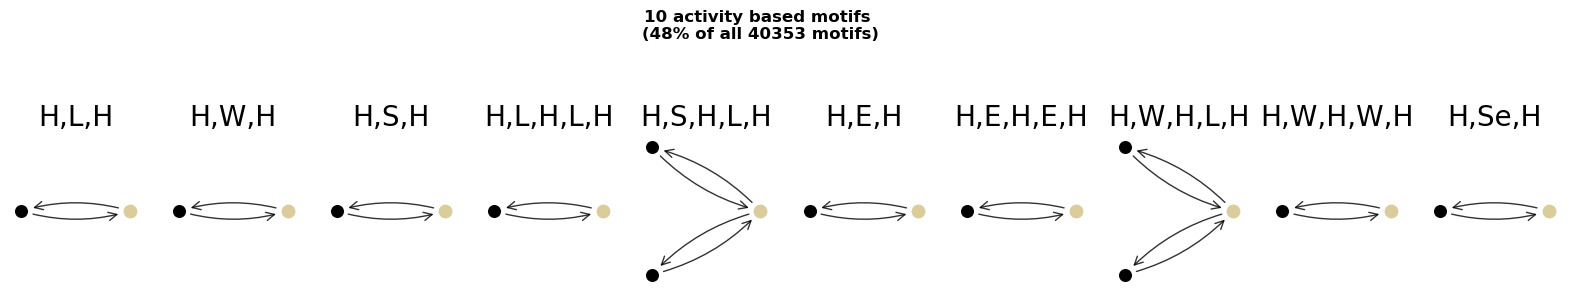

In [18]:
plot_motifs_purpose(10, mtf_tag, 'motif_type_str')

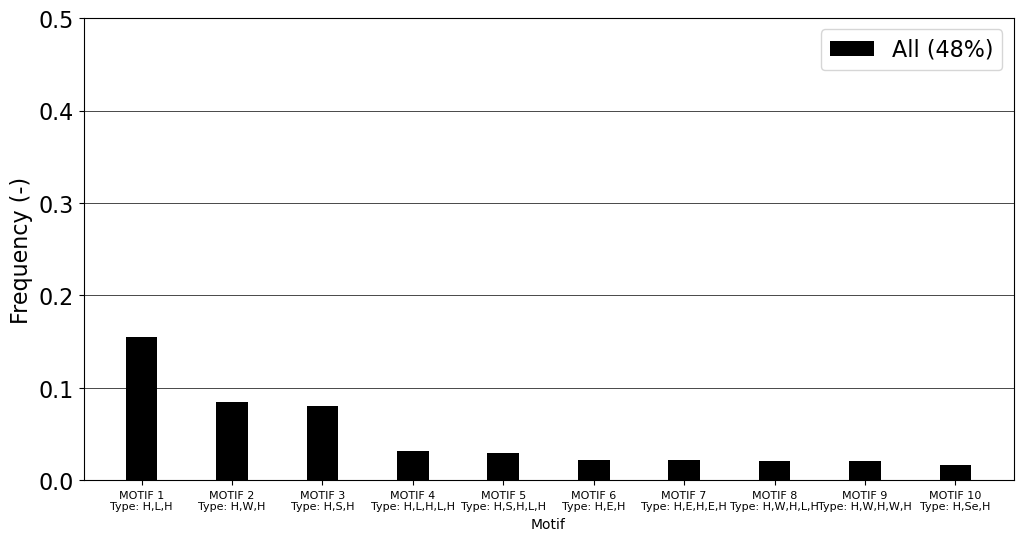

In [19]:
plot_motif_counts_purpose(10, mtf_tag, 'motif_type_str', mtf1_name='All', y_max=0.5, h=0.003)

### 3.1.2 WEEKDAYS

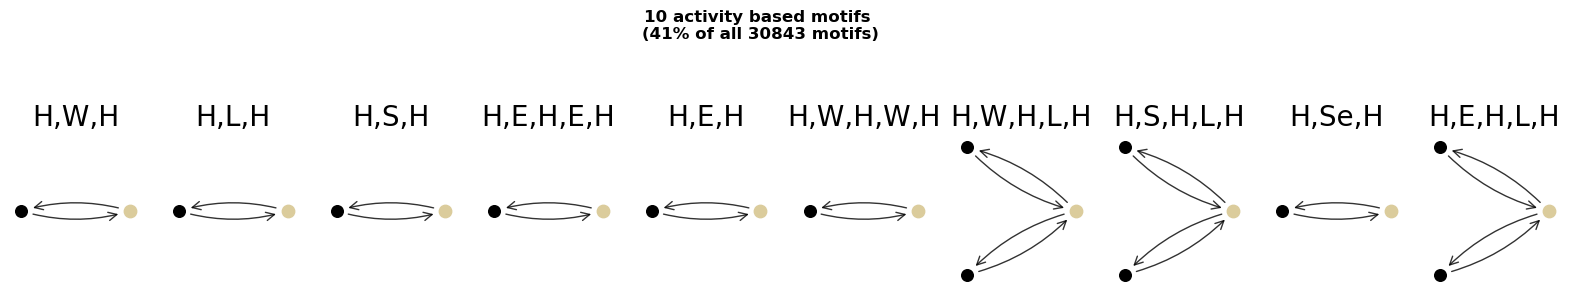

In [20]:
plot_motifs_purpose(10, mtf_weekdays, 'motif_type_str')

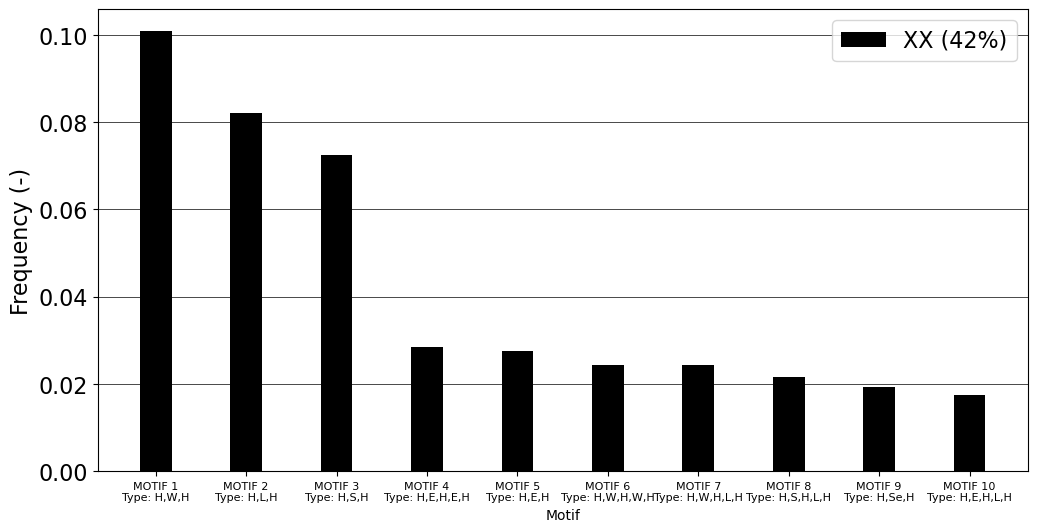

In [21]:
plot_motif_counts_purpose(10, mtf_weekdays, 'motif_type_str')

### 3.1.3 WEEKEND

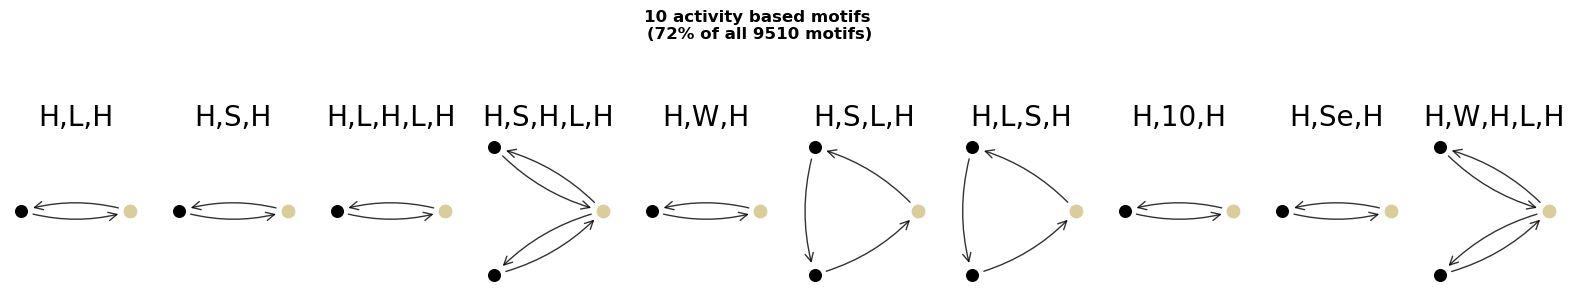

In [22]:
plot_motifs_purpose(10, mtf_weekend, 'motif_type_str')

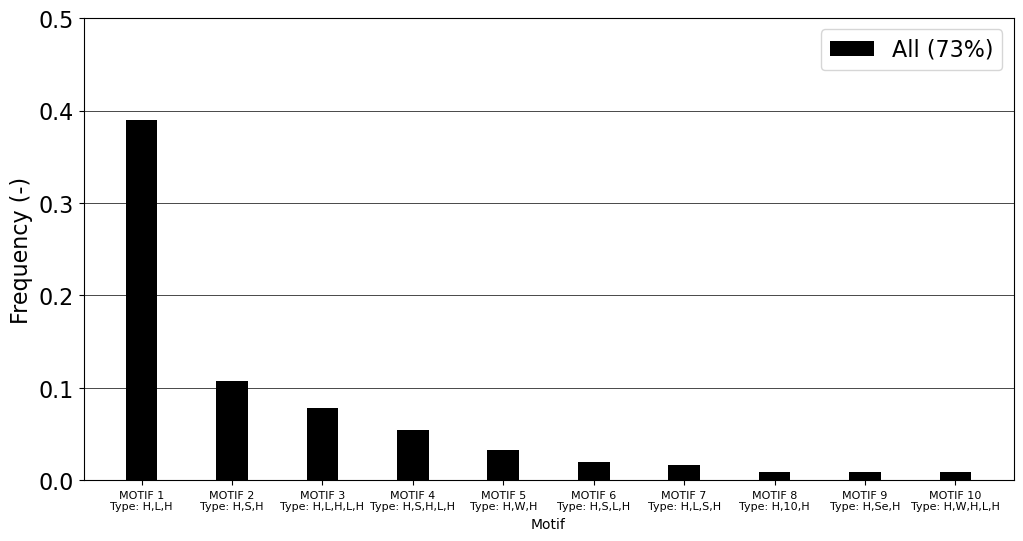

In [23]:
plot_motif_counts_purpose(10, mtf_weekend, 'motif_type_str', mtf1_name='All', y_max=0.5)

### 3.1.4 COMPARISON WEEKDAYS AND WEEKEND

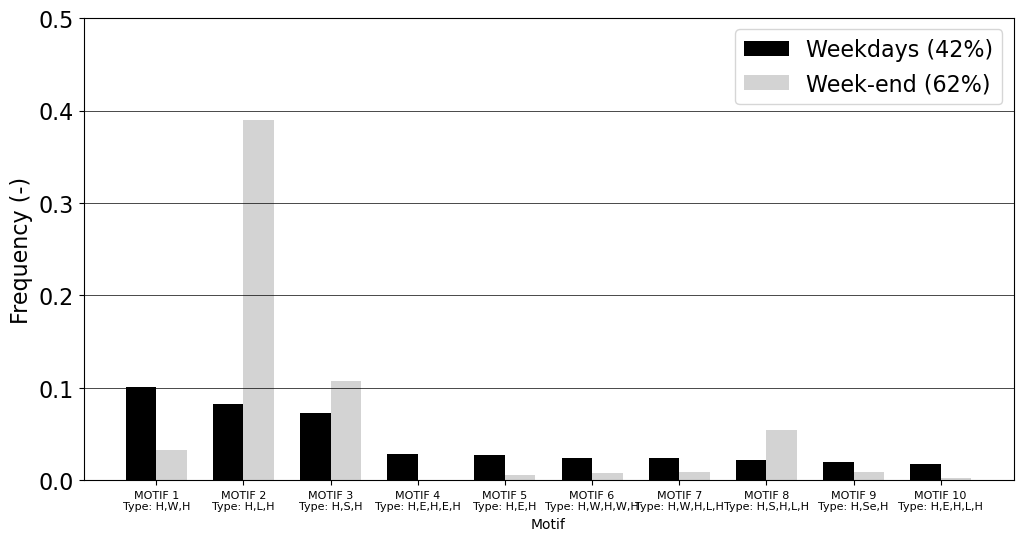

In [24]:
plot_motif_counts_purpose(10, mtf_weekdays, 'motif_type_str', mtf2=mtf_weekend, mtf1_name='Weekdays', mtf2_name='Week-end', 
                          y_max=0.5, h=0.013)

## 3.2 COMPARISON WITHIN EMPLOYMENT CATEGORIES

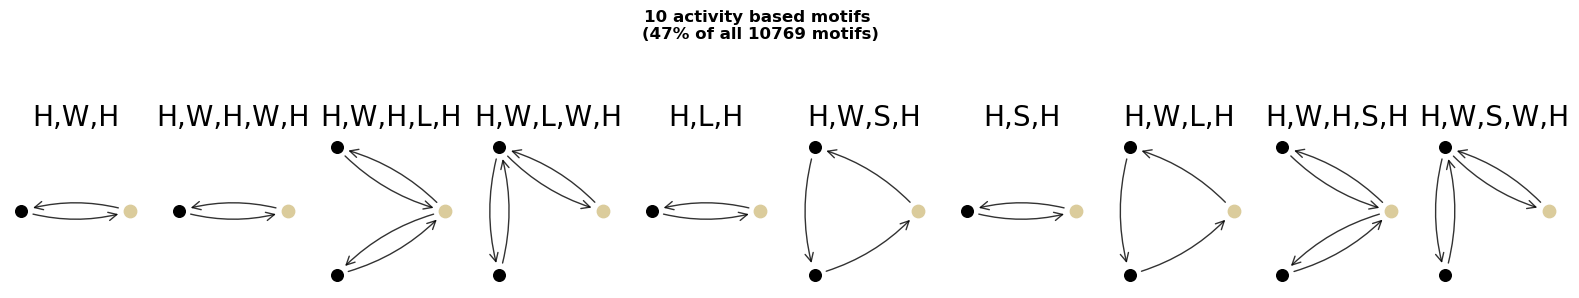

In [25]:
# Full-time worker
plot_motifs_purpose(10, mtf_wd_1, 'motif_type_str')

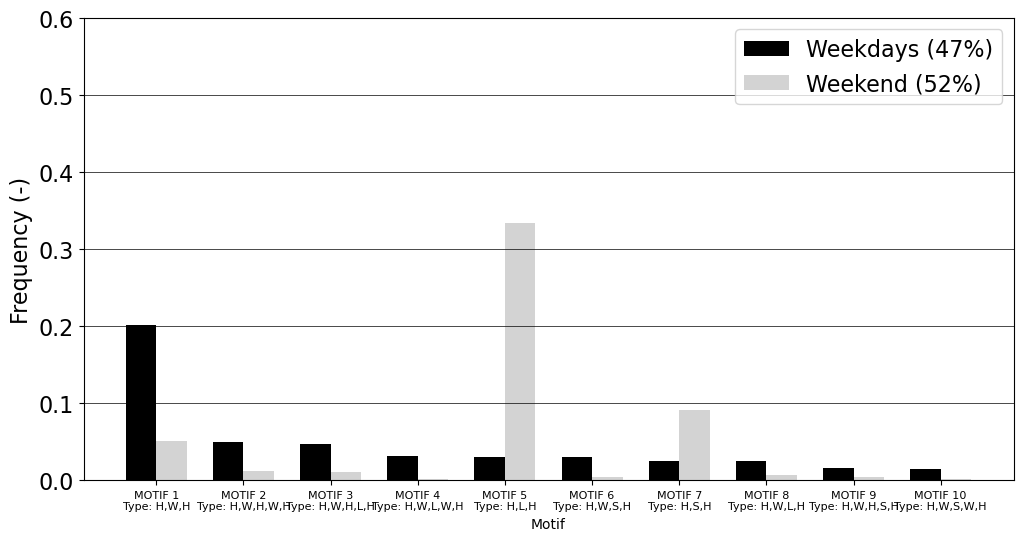

In [26]:
# Full-time worker weekend/weekdays
plot_motif_counts_purpose(10, mtf_wd_1, 'motif_type_str', mtf2=mtf_we_1, mtf1_name='Weekdays', mtf2_name='Weekend', y_max=0.6)

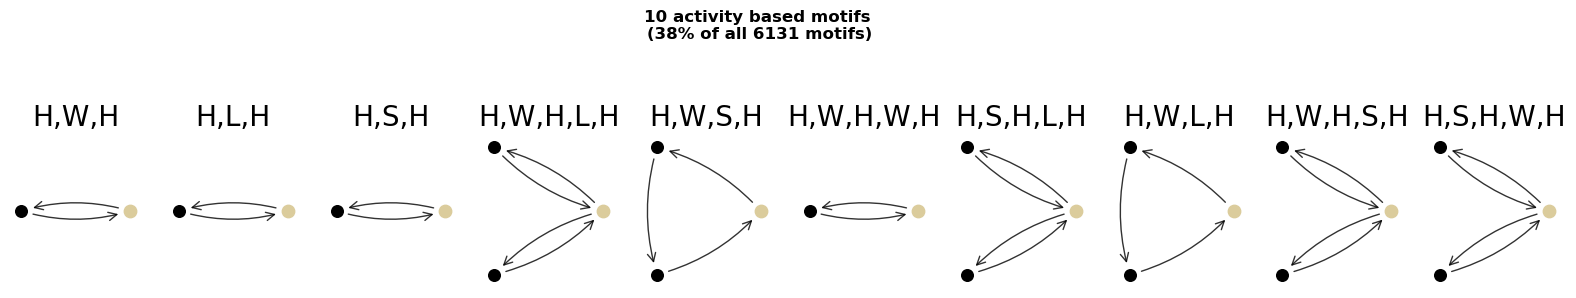

In [27]:
# Part-time worker
plot_motifs_purpose(10, mtf_wd_2, 'motif_type_str')

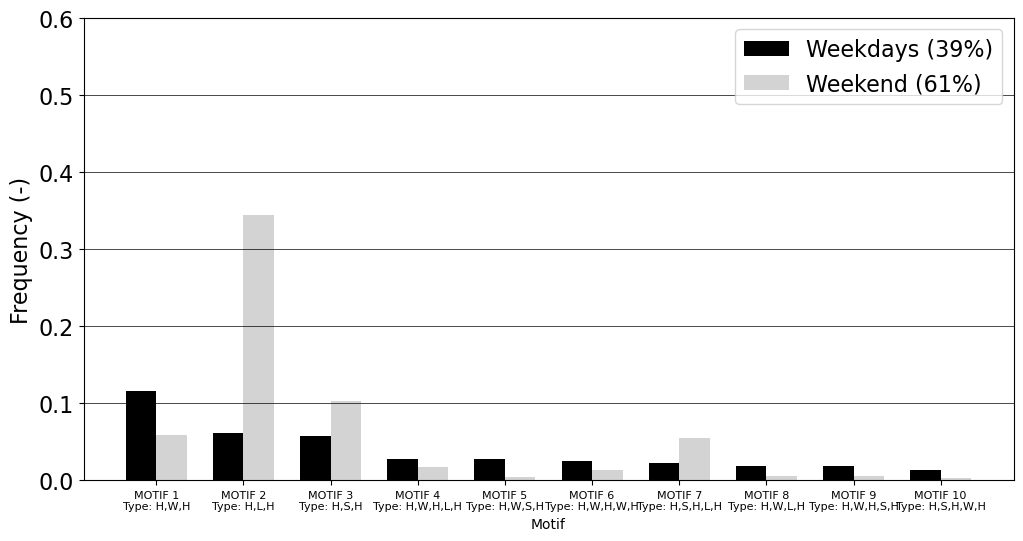

In [28]:
# Part-time worker weekend/weekdays
plot_motif_counts_purpose(10, mtf_wd_2, 'motif_type_str', mtf2=mtf_we_2, mtf1_name='Weekdays', mtf2_name='Weekend', y_max=0.6)

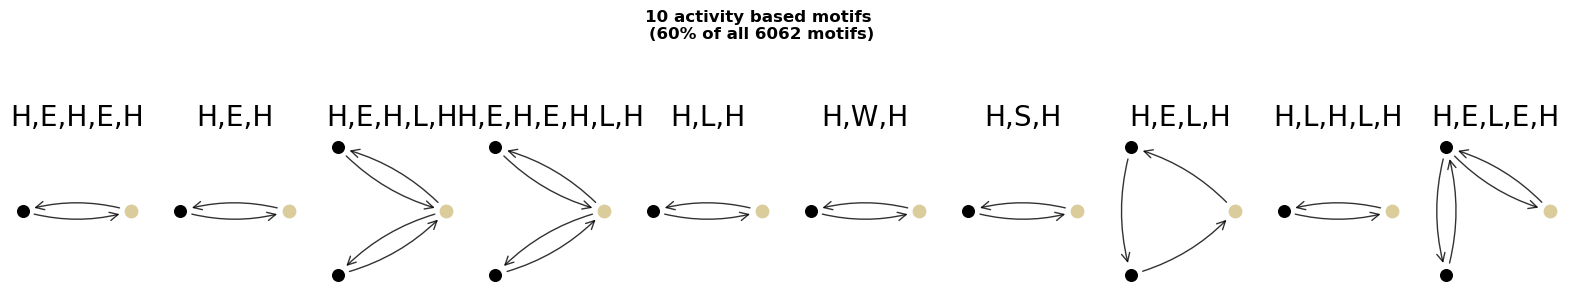

In [29]:
# Student
plot_motifs_purpose(10, mtf_wd_3, 'motif_type_str')

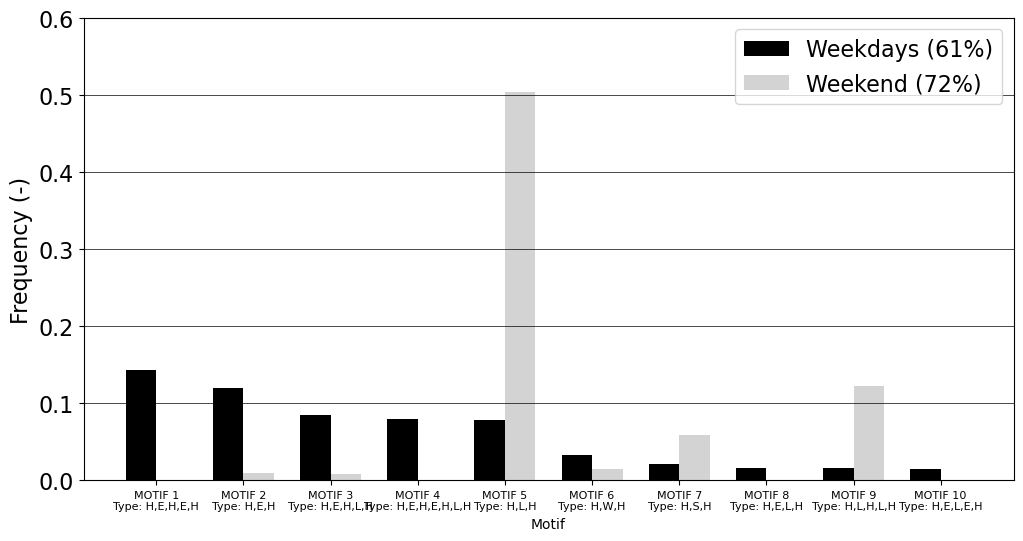

In [30]:
# Student weekend/weekdays
plot_motif_counts_purpose(10, mtf_wd_3, 'motif_type_str', mtf2=mtf_we_3, mtf1_name='Weekdays', mtf2_name='Weekend', y_max=0.6)

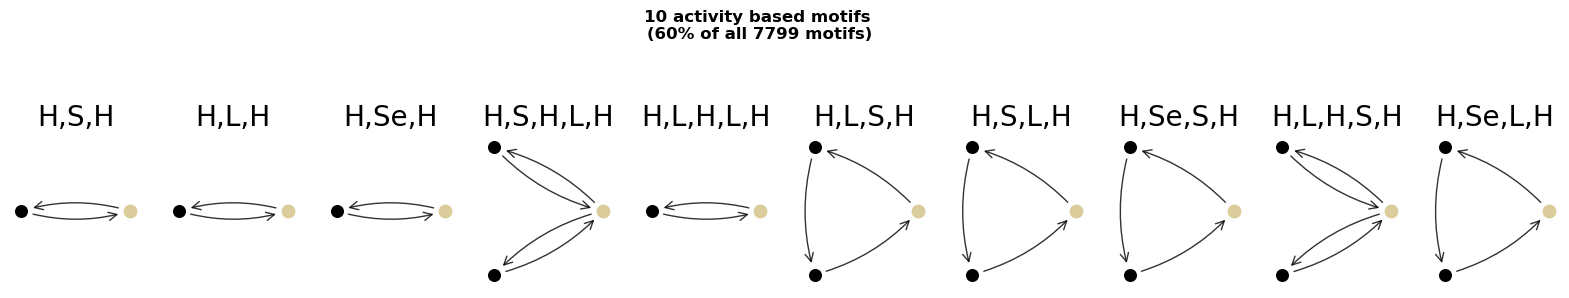

In [31]:
# Unemployed
plot_motifs_purpose(10, mtf_wd_4, 'motif_type_str')

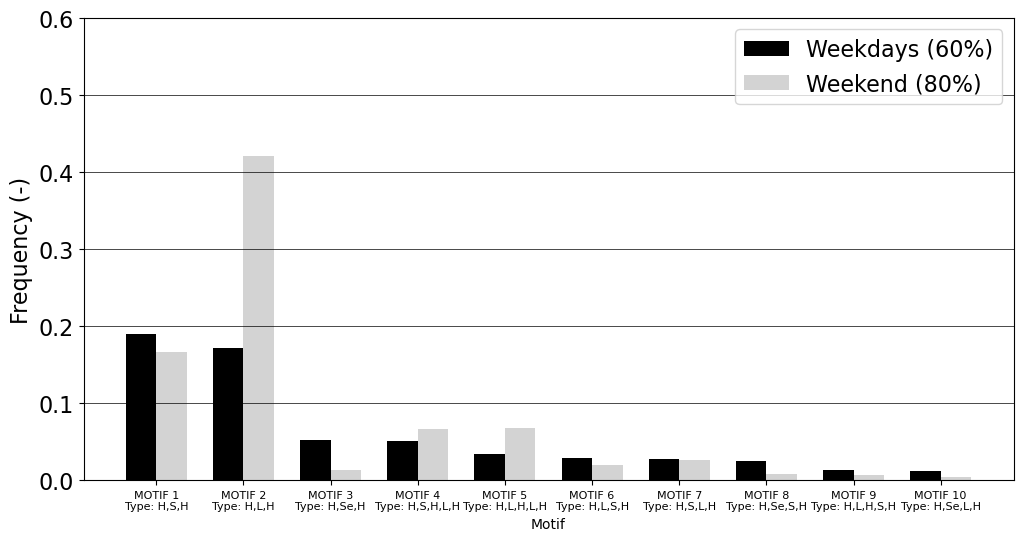

In [32]:
# Unemployed weekend/weekdays
plot_motif_counts_purpose(10, mtf_wd_4, 'motif_type_str', mtf2=mtf_we_4, mtf1_name='Weekdays', mtf2_name='Weekend', y_max=0.6)

## 4. CONDITIONAL ANALYSIS

### 4.1 Test to see problems

#### Child under 15 and working (ERWERB !=3)

In [33]:
mtf_cond = mtf_tag.copy()
mtf_cond = mtf_cond.loc[mtf_cond['alter'] < 15 ]
mtf_cond = mtf_cond.loc[mtf_cond['ERWERB'] !=3 ]
mtf_cond

,DiGraph_motif,motif_flat,motif_type,motif_id,alter,tag,employment_status,professional_pos,work_sektor12,work_sektor3,ERWERB,motif_type_str
HHNR,,,,,,,,,,,,


## 5. TIMINGS ANALYSIS

#### Steps to follow to get the timings and durations:

1. Browse the `mtf_tag` dataset according to all HHNRs and according to the `time` attribute of `DiGraph_motif`
2. Calculate time of each activity by doing `finished_at` - `started_at` iterating over each `time` node
3. Store each value in an array according to node type. Keep HHNR information
4. Merge all arrays into a single `duration` dataframe
5. Plot graphs for activity times, by activity

## 5.1 START TIME

In [34]:
%%time
# Initialize a dictionary to store the start times for each node type
start_dict = {}

# Iterate over the mtf_tag DataFrame
for idx, row in mtf_tag.iterrows():
    # Extract attribute data from DiGraph_motif
    node_attrs = nx.get_node_attributes(row['DiGraph_motif'], 'time')
    
    # Iterate over each node to calculate the start time of each activity
    for node, time in node_attrs.items():
        # Extract the start times for each activity of the node
        started_at_list = time['started_at']
        for i in range(len(started_at_list)):
            started_at = started_at_list[i]
            
            # Store the start times in the dictionary based on the node type and activity number
            node_type = node[0]
            activity_num = str(i+1)
            col_name = 'node_' + node_type + '_' + activity_num
            
            if col_name not in start_dict:
                start_dict[col_name] = {}
            start_dict[col_name][idx] = started_at
                    
# Create the 'start_time' DataFrame from the dictionary
start_time = pd.DataFrame.from_dict(start_dict)
start_time = start_time.sort_index(axis=1)
start_time.index.name = 'HHNR'

CPU times: total: 2.89 s
Wall time: 2.92 s


### 5.1.1 HOME

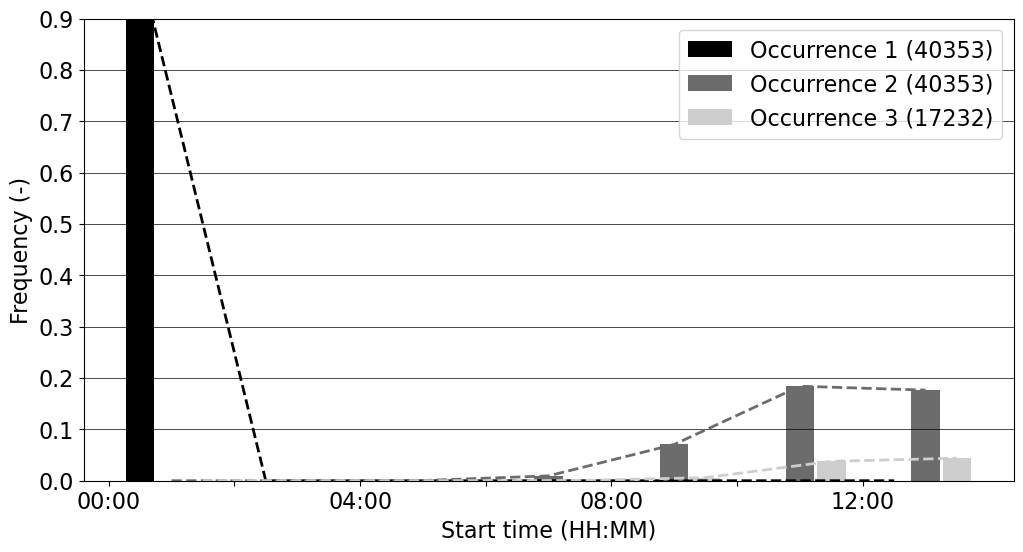

In [35]:
plot_histogram_hours(modify_dataframe(start_time), ['0'], 3, 120, typ='Start time', y_max=0.9, x_max=13*60)

### 5.1.2 WORK

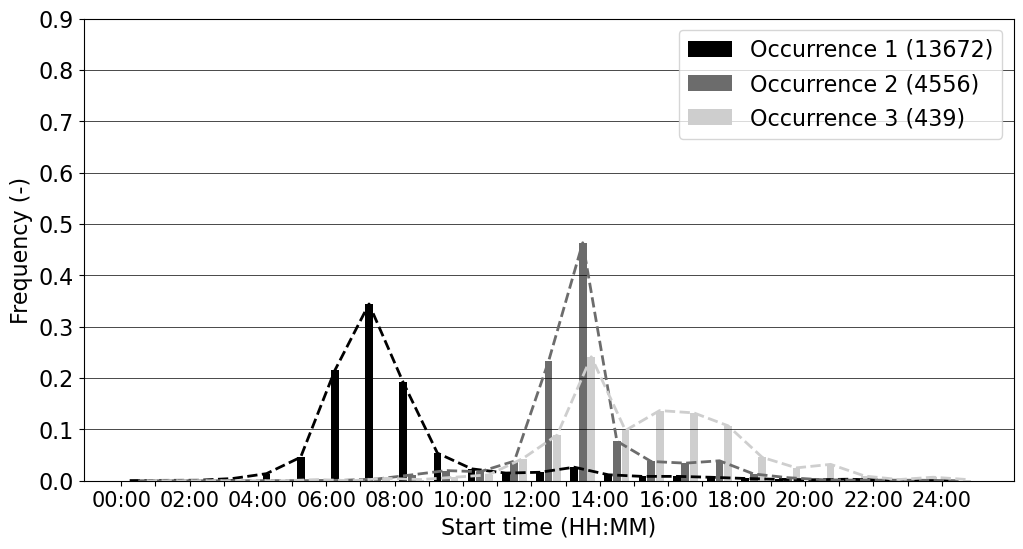

In [36]:
plot_histogram_hours(modify_dataframe(start_time), ['2'], 3, 60, typ='Start time', y_max=0.9, x_max=25*60, siz=15)

### 5.1.3 SCHOOL

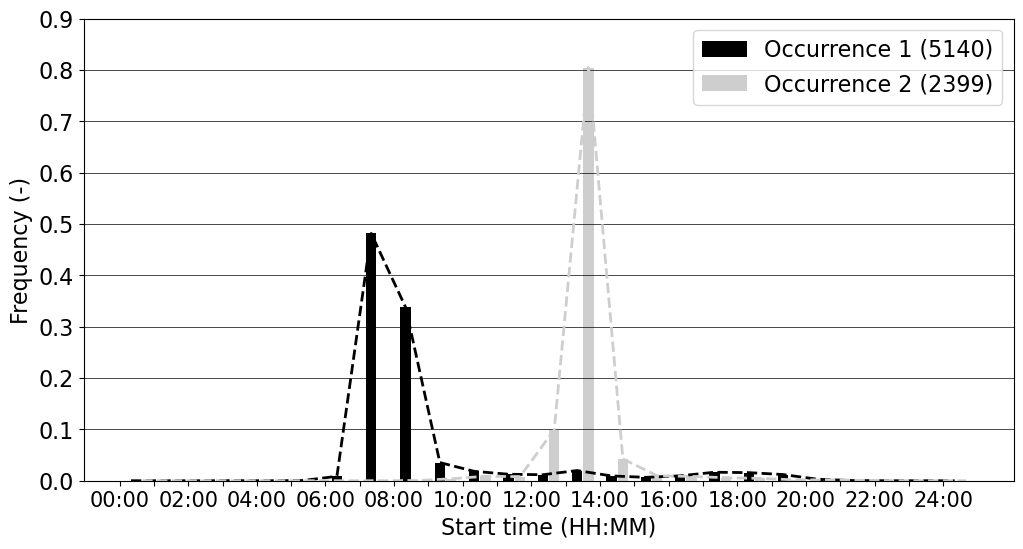

In [37]:
plot_histogram_hours(modify_dataframe(start_time), ['3'], 3, 60, typ='Start time', y_max=0.9, x_max=25*60, siz=15)

### 5.1.4 SHOPPING

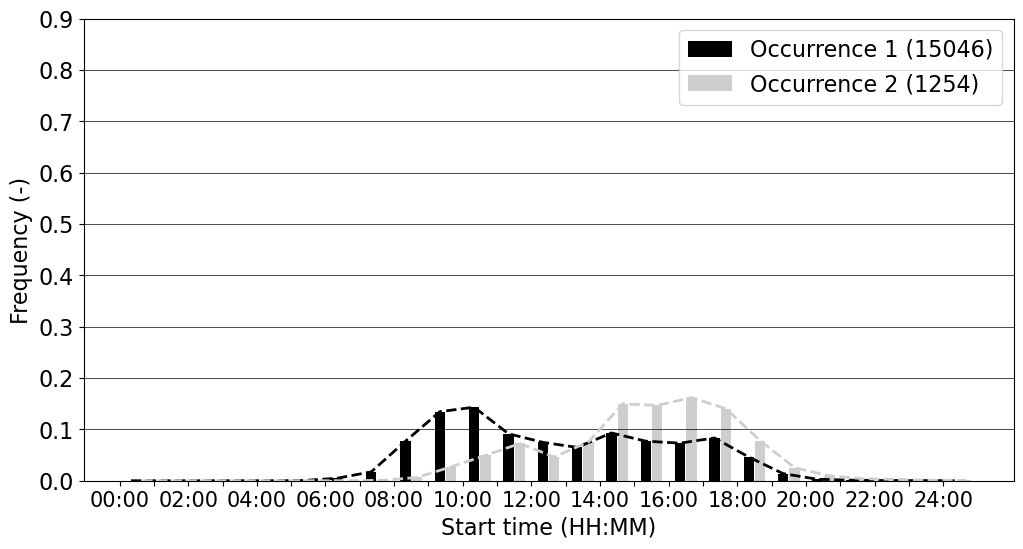

In [38]:
plot_histogram_hours(modify_dataframe(start_time), ['4'], 3, 60, typ='Start time', y_max=0.9, x_max=25*60, siz=15)

### 5.1.5 LEISURE

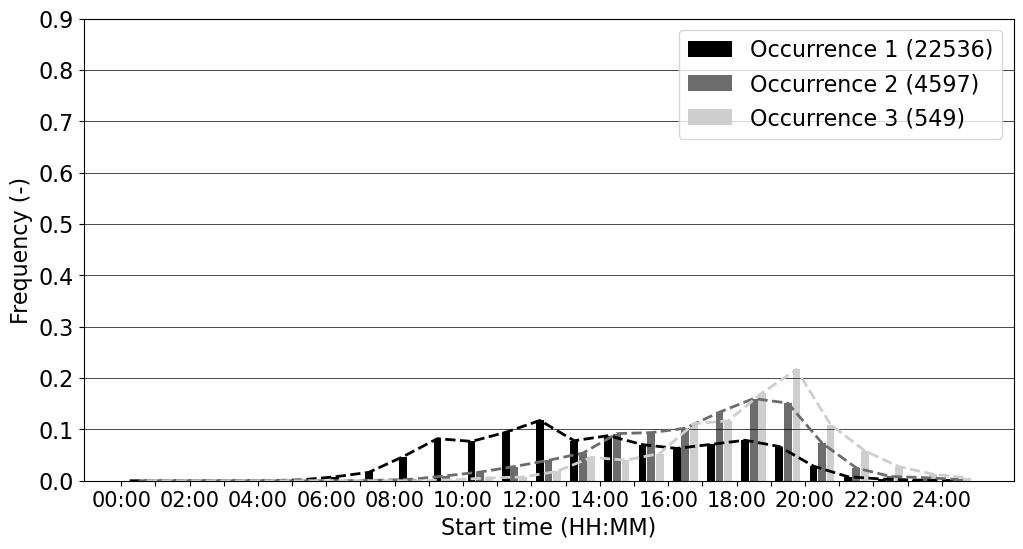

In [39]:
plot_histogram_hours(modify_dataframe(start_time), ['8'], 3, 60, typ='Start time', y_max=0.9, x_max=25*60, siz=15)

## 5.2 DURATION

In [40]:
%%time
# Initialize a dictionary to store durations for each node type
duration_dict = {}

# Iterate over the mtf_tag DataFrame
for idx, row in mtf_tag.iterrows():
    # Extract attribute data from the DiGraph_motif
    node_attrs = nx.get_node_attributes(row['DiGraph_motif'], 'time')
    
    # Iterate over each node to calculate activity duration
    for node, time in node_attrs.items():
        # Extract start and end times for each activity of the node
        started_at_list = time['started_at']
        finished_at_list = time['finished_at']
        for i in range(len(started_at_list)):
            started_at = started_at_list[i]
            finished_at = finished_at_list[i]
            
            # Calculate activity duration
            activity_duration = finished_at - started_at
            
            # Store activity duration in the dictionary based on node type and activity number
            node_type = node[0]
            activity_num = str(i+1)
            col_name = 'node_' + node_type + '_' + activity_num
            if col_name not in duration_dict:
                duration_dict[col_name] = {}
            duration_dict[col_name][idx] = activity_duration

# Create the 'duration' DataFrame from the dictionary
duration = pd.DataFrame.from_dict(duration_dict)
duration = duration.sort_index(axis=1)
duration.index.name = 'HHNR'

CPU times: total: 2.95 s
Wall time: 2.96 s


### 5.2.1 HOME

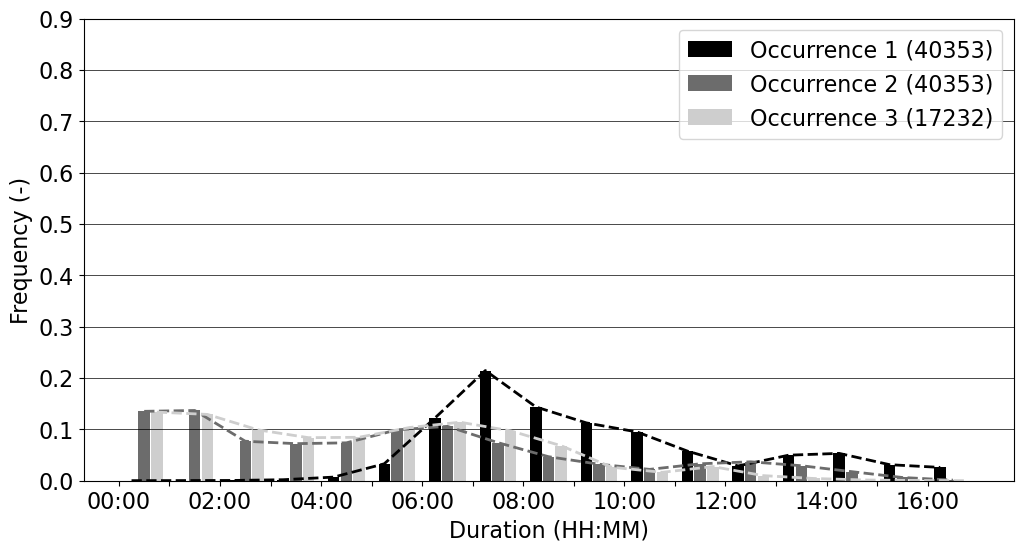

In [41]:
plot_histogram_hours(modify_dataframe(duration), ['0'], 3, 60, y_max=0.9, x_max=17*60)

### 5.2.2 WORK

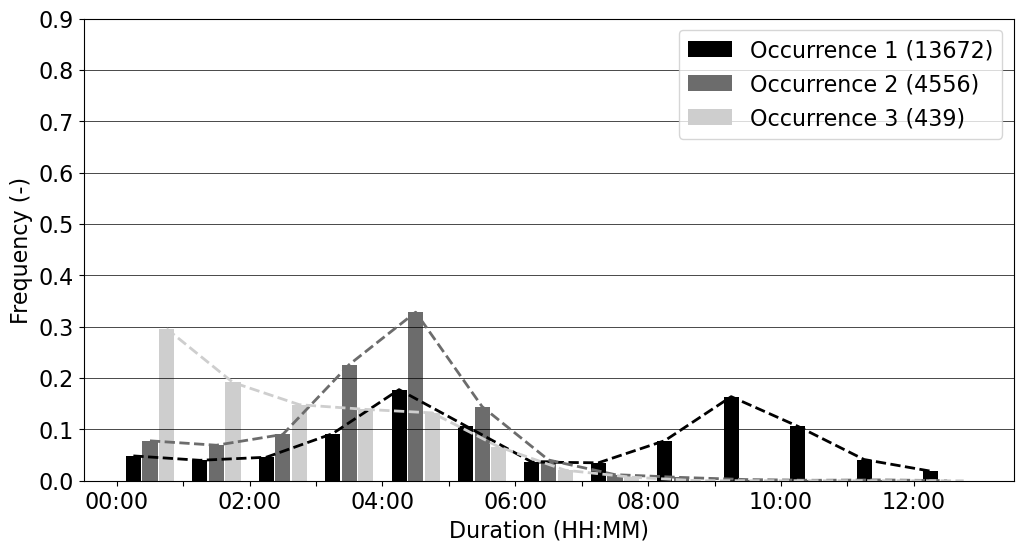

In [42]:
plot_histogram_hours(modify_dataframe(duration), ['2'], 3, 60, y_max=0.9, x_max=13*60)

### 5.2.3 SCHOOL

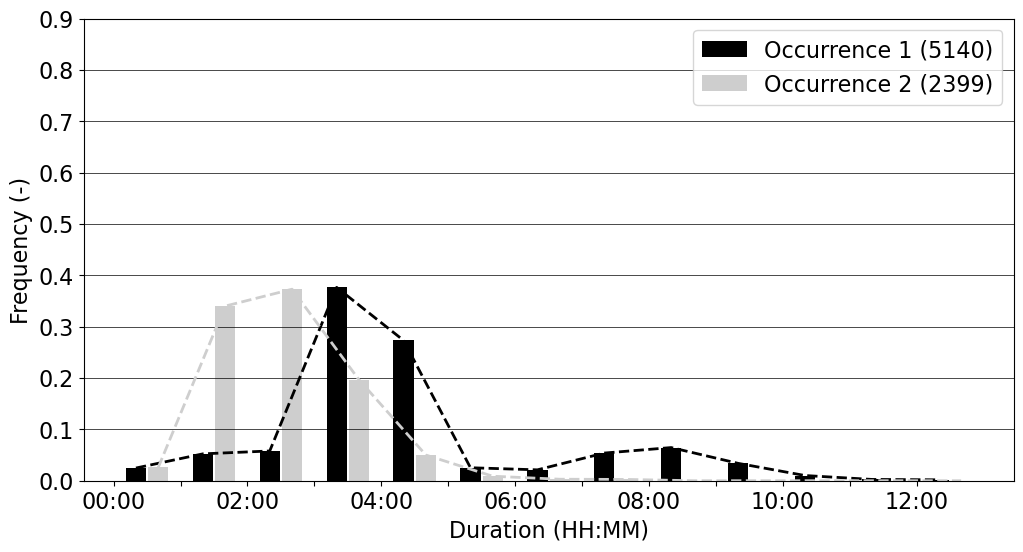

In [43]:
plot_histogram_hours(modify_dataframe(duration), ['3'], 3, 60, y_max=0.9, x_max=13*60)

### 5.2.4 SHOPPING

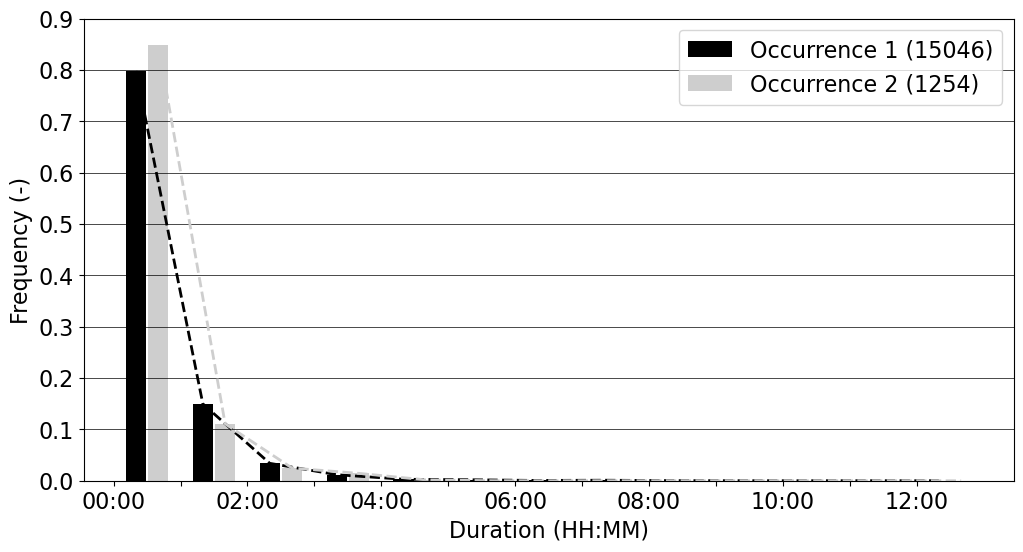

In [44]:
plot_histogram_hours(modify_dataframe(duration), ['4'], 3, 60, y_max=0.9, x_max=13*60)

### 5.2.5 LEISURE

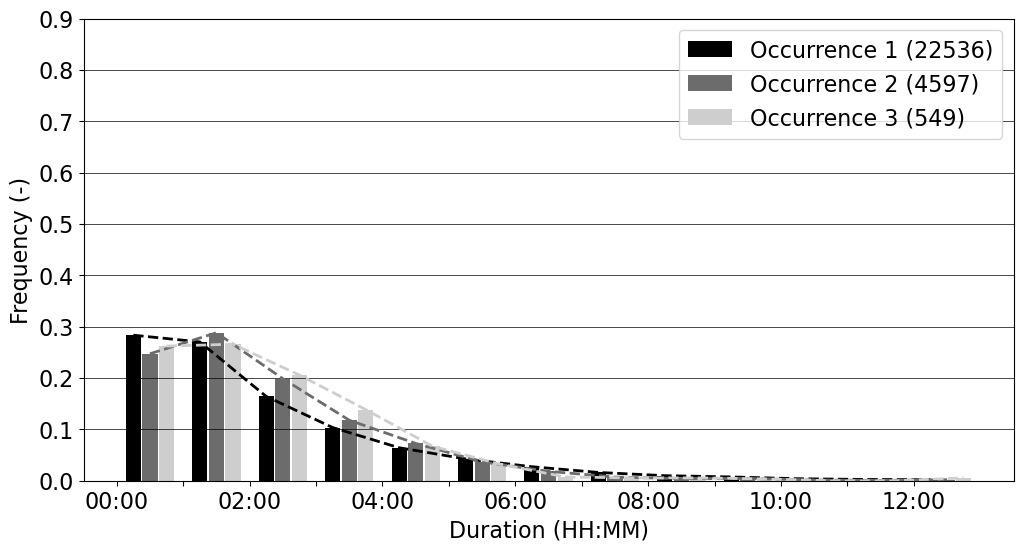

In [45]:
plot_histogram_hours(modify_dataframe(duration), ['8'], 3, 60, y_max=0.9, x_max=13*60)